# Audio Classification with Neural Networks 

### Introduction

In this project, I will delve into the realm of audio signal processing and machine learning by using MFCCs to extract features from audio and creating Neural Networks using PyTorch to perform this classification task.

we will make use of the `AudioMNIST` dataset: tens of thousands of audio samples of people with different accents, coming from different regions of the world, speaking different digits. You can download the dataset using [this link](https://drive.google.com/file/d/1EDbjnXFlmdnru1N36KpQR054dSpsixW8/view?usp=sharing).

## Imports

In [12]:
import glob
import random

import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

## Creating the Dataset 

We start by extracting Mel-frequency Cepstral Coefficients (MFCCs) from audio messages, a fundamental step in audio feature extraction. MFCCs are widely used for their effectiveness in capturing the essential characteristics of audio signals, making them an ideal choice for our classification task.

The dataset consists of 60 folders, each one corresponding to a different speaker with a different accent. Each folder contains 500 audio files, with each one corresponding to a different utterance of a digit from 0 to 9.

Let's play one of them.

In [13]:
# Play audio (might have to turn your volume up!)
import IPython.display as ipd

sample_path = "data/02/0_02_0.wav"
ipd.Audio(sample_path)

To feed data like this to any model, we have to think of a way to represent the input as features. One technique that lets us extract features from raw audio samples, is to calculate the MFCCs (as mentioned before) for each one. the main takeaway is that it is a technique with which to *represent* an audio sample as a **fixed-size vector of features**.

WE will make use of the `librosa` library to perform the operations.

In [14]:
# Grab all the files ending with .wav using glob.glob
wav_paths = glob.glob('data/' + '**/*.wav')
random.shuffle(wav_paths)

print(len(wav_paths))
print(wav_paths)

30000
['data/27/7_27_11.wav', 'data/59/4_59_6.wav', 'data/07/3_07_43.wav', 'data/01/0_01_19.wav', 'data/34/7_34_20.wav', 'data/18/0_18_37.wav', 'data/55/7_55_3.wav', 'data/34/9_34_41.wav', 'data/47/9_47_4.wav', 'data/14/4_14_33.wav', 'data/17/0_17_28.wav', 'data/58/7_58_21.wav', 'data/30/2_30_12.wav', 'data/51/1_51_45.wav', 'data/02/7_02_19.wav', 'data/09/1_09_24.wav', 'data/52/9_52_10.wav', 'data/53/3_53_25.wav', 'data/19/2_19_16.wav', 'data/15/2_15_7.wav', 'data/28/7_28_16.wav', 'data/48/1_48_27.wav', 'data/39/8_39_49.wav', 'data/10/7_10_46.wav', 'data/24/7_24_31.wav', 'data/19/0_19_19.wav', 'data/06/3_06_0.wav', 'data/23/9_23_44.wav', 'data/36/7_36_45.wav', 'data/18/7_18_30.wav', 'data/45/1_45_11.wav', 'data/03/9_03_39.wav', 'data/14/6_14_11.wav', 'data/08/2_08_17.wav', 'data/33/8_33_4.wav', 'data/49/5_49_44.wav', 'data/21/1_21_44.wav', 'data/02/7_02_43.wav', 'data/17/6_17_48.wav', 'data/08/6_08_11.wav', 'data/26/7_26_23.wav', 'data/29/9_29_40.wav', 'data/48/4_48_5.wav', 'data/54/6_

In [ ]:

def generate_features(fpath):
    '''
    Generate 40 MFCC features from the argument audio file as input to the model
    '''

    # Load in the file using librosa
    audio, sample_rate = librosa.load(fpath, sr=None)

    # Trim the audio file
    trimsize = int(3 * sample_rate)
    audio = audio[:trimsize] #keepin first 3 secs of audio

    # Generate the MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

    # Generate the features by taking the mean of the transpose MFCCs along axis=0
    mfccs_transposed = mfccs.T
    mfccs_final = np.mean(mfccs_transposed, axis=0)
    
    return mfccs_final

def get_label(fpath):
    '''
    Get the label from the filepath
    Example:
    1_23_4.wav -> 1
    '''
    return (fpath.split('_')[0])[-1]

def create_dataset(fnames):
    '''
    Create the dataset, i.e. features and labels, from the list of filepaths
    '''
    features = []
    labels = []
    
    for i, fpath in enumerate(fnames):
        if i % (len(fnames) // 10) == 0 or i == len(fnames)-1:
            print(f'Processing {i} of {len(fnames)} files')
    
        features.append(generate_features(fpath))
        labels.append(get_label(fpath))
    
    return features, labels
    
features, labels = create_dataset(wav_paths)

np.save('features.npy', np.asarray(features))
np.save('labels.npy', np.asarray(labels))

X, y = np.load('features.npy'), np.load('labels.npy')
print(X.shape, y.shape)

# print(get_label(wav_paths[0]))

Processing 0 of 30000 files
Processing 3000 of 30000 files
Processing 6000 of 30000 files
Processing 9000 of 30000 files
Processing 12000 of 30000 files
Processing 15000 of 30000 files
Processing 18000 of 30000 files
Processing 21000 of 30000 files


In [ ]:
# # Convert to tensors
y = np.array([int(label) for label in y])
X = torch.tensor(X, dtype= torch.float32)
y = torch.tensor(y, dtype=torch.int32)

# train-test split (stratify using the labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 666)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# print(y)
# print(y_train)

## Creating and Training an Audio Classifier 

Now that we've finally gotten the dataset in a numericalized form fit for a model, we can move to creating the actual model. 

We will be using PyTorch to create a Neural Network that can classify the audio samples. It can be helpful to go through the following chapter before one starts: [PyTorch Classification by learnpytorch.io](https://www.learnpytorch.io/02_pytorch_classification/).

In general, when creating the model, I find it to be important to be mindful of the following points:

- You must make use of `torch.nn` when creating your model (it has already been imported for you).

- The input size of the model should be the same as the size of the feature vectors.

- The output size of the model should be 10, since there are 10 classes. Note that this also implies you should be using the Cross Entropy Loss function (which is `nn.CrossEntropyLoss` in PyTorch).

- You can make any sized model you want, but note that smaller architectures train faster and work well for this task.

- There must be non-linear activation functions between the layers: try `nn.ReLU` or `nn.Tanh`.

In [ ]:
## TODO: Create an AudioClassifier class (10 Marks)
class AudioClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AudioClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# TODO: Instantiate the model
model = AudioClassifier(40, 10)

# TODO: Create the loss function
loss_fn = nn.CrossEntropyLoss()

# TODO: Create the optimizer (use Adam)
optimizer = torch.optim.Adam(model.parameters())

The last step is to create **training and evaluation** loops for our model.

In [ ]:
def fit_one_epoch(model,
                  X, y,
                  optimizer, loss_fn):
    '''
    Perform one epoch of training
    '''
    # Set the model in train mode
    model.train()
    
    # TODO: Forward Pass (get the logits)
    logits = model(X)

    # TODO: Calculate the loss
    loss = loss_fn(logits, y)

    # TODO: Optimizer zero grad
    optimizer.zero_grad()

    # TODO: Backward pass
    loss.backward()

    # TODO: Step the optimizer
    optimizer.step()

    # Calculate the accuracy
    # Hint: Take the argmax of the logits along the last axis and compare with y
    predictions = torch.argmax(logits, dim=1)
    correct_predictions = (predictions == y).sum().item()
    total_predictions = y.size(0)
    acc = correct_predictions / total_predictions

    return loss, acc

@torch.no_grad()
def evaluate(model,
             X, y,
             loss_fn):
    '''
    Perform one epoch of evaluation
    '''
    # Set the model in eval mode
    model.eval()

    # TODO: Forward Pass (get the logits)
    logits = model(X)
    
    # TODO: Calculate the loss
    loss = loss_fn(logits, y)

    # TODO: Calculate the accuracy
    predictions = torch.argmax(logits, dim=1)
    correct_predictions = (predictions == y).sum().item()
    total_predictions = y.size(0)
    acc = correct_predictions / total_predictions

    return loss, acc

def fit(model,
        X_train, y_train, X_val, y_val,
        optimizer, loss_fn,
        epochs=200):
    '''
    Perform the entire training process
    '''

    # Create a history object to store the losses and accuracies
    history = {k: [] for k in ["train_loss", "train_acc", "val_loss", "val_acc"]}
    
    for epoch in range(epochs):
        # TODO: Training step
        train_loss, train_acc = fit_one_epoch(model, X_train, y_train, optimizer, loss_fn)
        
        # TODO: Evaluation step
        val_loss, val_acc = evaluate(model, X_val, y_val, loss_fn)
        
        # Optional logging
        if epoch % (epochs//10) == 0 or epoch == epochs-1:
            print(f"Epoch {epoch} | Train loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

        # Save the losses and accuracies to the history object    
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
    
    return history

In [ ]:
# Fit the model and plot the losses
history = fit(model, X_train, y_train.long(), X_test, y_test.long(), optimizer, loss_fn, epochs=500)

# Save the model
torch.save(model.state_dict(), 'audio_classifier.pth')

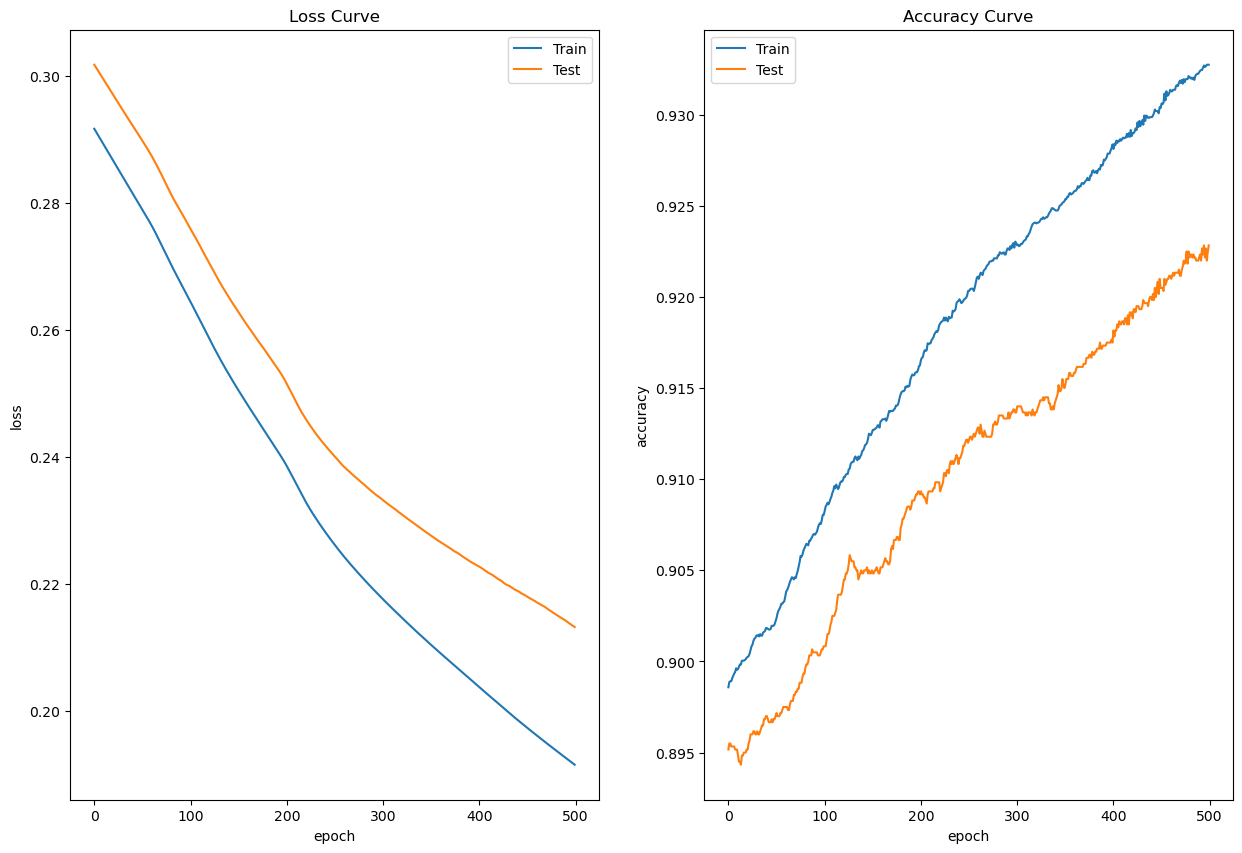

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.plot([item.detach().numpy() for item in history['train_loss']], label='Train')
ax1.plot([item.detach().numpy() for item in history['val_loss']], label='Test')

ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax1.set_title("Loss Curve")
ax1.legend()

ax2.plot(history['train_acc'], label='Train')
ax2.plot(history['val_acc'], label='Test')

ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')

ax2.set_title("Accuracy Curve")
ax2.legend()

plt.show()

### Inference on Custom Sample 

Now that we've trained our model, we can use it to make predictions on custom audio samples. Note that we must apply the same preprocessing steps for feature extraction as before, since our model only knows and is configured to work for that.

In [23]:
@torch.no_grad()
def predict(fpth, model):
    '''
    Performs end-to-end inference on a sample audio file.
    '''
    features = generate_features(fpth)
    features = torch.tensor(features, dtype=torch.float32).unsqueeze(0) 

    # now we perform inference (get the final prediction and the corresponding probability)
    logits = model(features)
    predicted_class_idx = torch.argmax(logits, dim=1)
    probs = torch.nn.functional.softmax(logits, dim=1)
    conf = probs[0, predicted_class_idx].item()
    pred = predicted_class_idx.item()

    return pred, conf

In [24]:
x = random.choice(wav_paths)

pred, conf = predict(x, model)
print(f"Predicted class `{pred}` with confidence {(conf*100):.2f}%")

ipd.Audio(x)

Predicted class `3` with confidence 72.72%
